In [1]:
# Install dependencies
!pip install torch torchvision onnx numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [3]:

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import onnx
import matplotlib.pyplot as plt


In [4]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:

# Load MobileNetV2 with updated weights syntax
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.last_channel, 10)  # Adjust for CIFAR-10
model = model.to(device)
print("MobileNetV2 loaded")

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
print("CIFAR-10 loaded")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 75.2MB/s]


MobileNetV2 loaded


100%|██████████| 170M/170M [00:08<00:00, 20.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR-10 loaded


In [6]:
# Split into 5 nodes
num_nodes = 5
samples_per_node = len(trainset) // num_nodes
node_datasets = [Subset(trainset, range(i * samples_per_node, (i + 1) * samples_per_node)) for i in range(num_nodes)]
node_loaders = [DataLoader(dataset, batch_size=32, shuffle=True) for dataset in node_datasets]
testloader = DataLoader(testset, batch_size=32, shuffle=False)
print(f"Split into {num_nodes} nodes, each with {samples_per_node} samples")

# Training function
def train_node(model, loader, node_id):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 10 == 9:  # Log every 10 batches
            losses.append(loss.item())
            print(f"Node {node_id}, Batch {i+1}: Loss {loss.item():.3f}")
    return losses


Split into 5 nodes, each with 10000 samples


In [7]:

# Train each node and collect losses
node_models = []
node_losses = {}
for i, loader in enumerate(node_loaders):
    print(f"\nTraining Node {i}")
    node_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    node_model.classifier[1] = nn.Linear(node_model.last_channel, 10)
    node_model = node_model.to(device)
    node_losses[i] = train_node(node_model, loader, i)
    node_models.append(node_model)


Training Node 0
Node 0, Batch 10: Loss 1.672
Node 0, Batch 20: Loss 1.104
Node 0, Batch 30: Loss 1.193
Node 0, Batch 40: Loss 1.291
Node 0, Batch 50: Loss 1.242
Node 0, Batch 60: Loss 0.839
Node 0, Batch 70: Loss 0.561
Node 0, Batch 80: Loss 1.055
Node 0, Batch 90: Loss 0.792
Node 0, Batch 100: Loss 0.886
Node 0, Batch 110: Loss 0.572
Node 0, Batch 120: Loss 0.743
Node 0, Batch 130: Loss 0.676
Node 0, Batch 140: Loss 0.589
Node 0, Batch 150: Loss 0.443
Node 0, Batch 160: Loss 0.744
Node 0, Batch 170: Loss 0.583
Node 0, Batch 180: Loss 0.710
Node 0, Batch 190: Loss 0.641
Node 0, Batch 200: Loss 0.411
Node 0, Batch 210: Loss 0.461
Node 0, Batch 220: Loss 0.992
Node 0, Batch 230: Loss 0.474
Node 0, Batch 240: Loss 0.793
Node 0, Batch 250: Loss 0.551
Node 0, Batch 260: Loss 0.816
Node 0, Batch 270: Loss 0.862
Node 0, Batch 280: Loss 0.589
Node 0, Batch 290: Loss 0.640
Node 0, Batch 300: Loss 0.663
Node 0, Batch 310: Loss 0.515

Training Node 1
Node 1, Batch 10: Loss 1.552
Node 1, Batch 20

In [8]:
import torchvision

# Average weights
def average_models(node_models):
    global_model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)
    global_model.classifier[1] = nn.Linear(global_model.last_channel, 10)
    global_model = global_model.to(device)


    state_dicts = [model.state_dict() for model in node_models]
    avg_state_dict = {}

    # Average only float tensors
    for key in state_dicts[0].keys():
        tensors = [sd[key] for sd in state_dicts]
        if tensors[0].dtype in [torch.float32, torch.float64]:
            avg_state_dict[key] = torch.stack(tensors, dim=0).mean(dim=0)
        else:
            avg_state_dict[key] = tensors[0]

    global_model.load_state_dict(avg_state_dict)
    return global_model

global_model = average_models(node_models)
print("Global model created")

Global model created


In [11]:
import torch
import torch.nn as nn
from torch.quantization import quantize_dynamic

#global_model starts on CPU for quantization
global_model = global_model.cpu()
global_model.eval()
quantized_model = quantize_dynamic(
    global_model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8
)
quantized_model = quantized_model.cpu()
print("Quantized model created (PyTorch, CPU)")

# Test accuracy on CPU
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.cpu(), labels.cpu()
        outputs = quantized_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
quant_accuracy = 100 * correct / total
print(f"Quantized model accuracy (PyTorch, CPU): {quant_accuracy:.2f}%")


import os
torch.save(global_model.state_dict(), "global_model.pth")
torch.save(quantized_model.state_dict(), "quantized_model.pth")
global_size = os.path.getsize("global_model.pth") / 1024**2
quant_size = os.path.getsize("quantized_model.pth") / 1024**2
print(f"Global model size: {global_size:.1f} MB")
print(f"Quantized model size: {quant_size:.1f} MB")

Quantized model created (PyTorch, CPU)
Quantized model accuracy (PyTorch, CPU): 88.64%
Global model size: 8.8 MB
Quantized model size: 8.7 MB


In [12]:
import matplotlib.pyplot as plt
import numpy as np

node_losses = {
    0: [1.685, 1.173, 1.150, 1.105, 1.147, 0.983, 0.986, 0.774, 0.696, 0.918, 1.016, 0.965, 0.918, 0.877, 0.873, 0.919, 0.806, 0.915, 0.785, 0.906, 0.755, 0.826, 0.707, 0.681, 0.727, 0.722, 0.771, 0.850, 0.655, 0.665, 0.680],
    1: [1.717, 1.339, 1.324, 1.244, 1.067, 0.941, 0.986, 0.901, 0.748, 0.986, 0.965, 0.772, 0.931, 0.906, 0.978, 0.851, 0.731, 0.814, 0.812, 0.766, 0.774, 0.780, 0.816, 0.893, 0.753, 0.672, 0.766, 0.738, 0.623, 0.700, 0.698],
    2: [1.751, 1.545, 1.240, 1.203, 1.012, 0.912, 1.032, 0.850, 0.953, 1.002, 0.868, 0.850, 0.860, 0.720, 0.912, 0.884, 0.794, 0.736, 0.901, 0.801, 0.735, 0.770, 0.666, 0.827, 0.676, 0.601, 0.861, 0.790, 0.826, 0.738, 0.640],
    3: [1.736, 1.382, 1.263, 1.245, 1.040, 0.968, 1.042, 0.942, 1.056, 0.863, 0.974, 0.947, 0.889, 0.861, 0.910, 0.892, 0.779, 0.844, 0.727, 0.733, 0.842, 0.934, 0.804, 0.747, 0.672, 0.728, 0.672, 0.786, 0.663, 0.902, 0.584],
    4: [1.720, 1.406, 1.364, 1.172, 1.071, 1.052, 1.047, 1.032, 1.055, 0.892, 0.824, 0.711, 0.835, 0.740, 0.735, 0.709, 0.745, 0.785, 0.904, 0.773, 0.885, 0.772, 0.817, 0.792, 0.663, 0.736, 0.779, 0.606, 0.672, 0.669, 0.695]
}

global_accuracy = 88.57
quant_accuracy = 88.64
model_sizes = {'Global': 8.8, 'Quantized': 8.7}


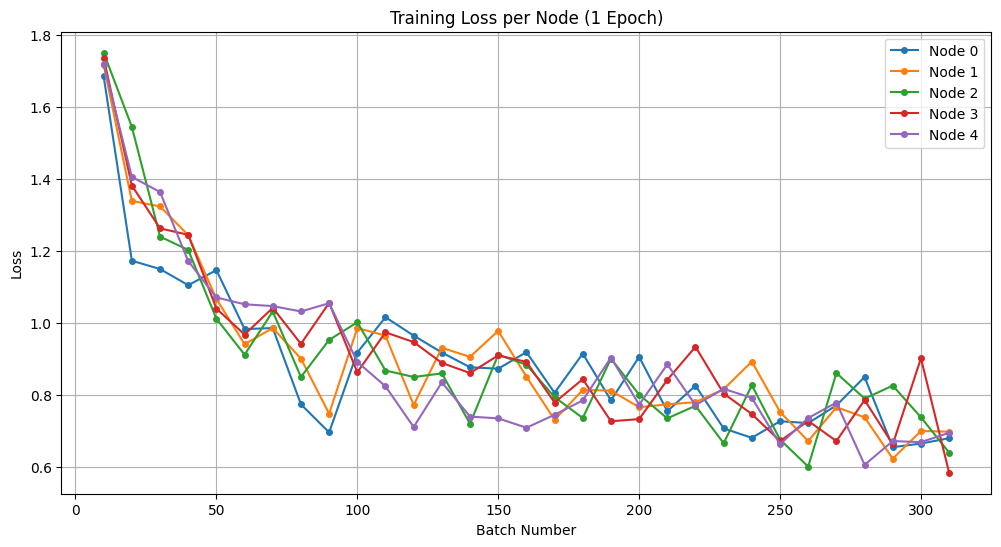

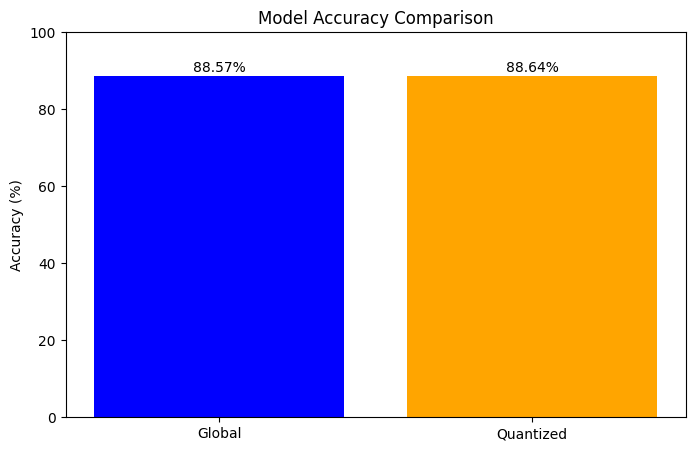

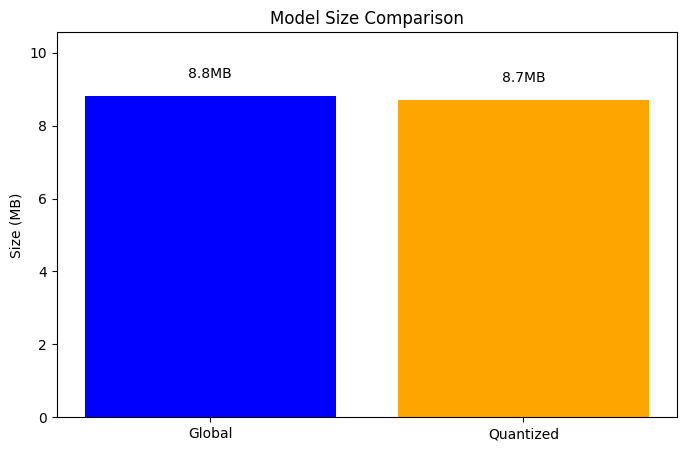

In [13]:
plt.figure(figsize=(12, 6))
batches = np.arange(10, 320, 10)
for node_id, losses in node_losses.items():
    plt.plot(batches, losses, label=f'Node {node_id}', marker='o', markersize=4)
plt.title('Training Loss per Node (1 Epoch)')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#Accuracy Comparison
plt.figure(figsize=(8, 5))
models = ['Global', 'Quantized']
accuracies = [global_accuracy, quant_accuracy]
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')
plt.show()

#Model Size
plt.figure(figsize=(8, 5))
sizes = [model_sizes['Global'], model_sizes['Quantized']]
plt.bar(models, sizes, color=['blue', 'orange'])
plt.title('Model Size Comparison')
plt.ylabel('Size (MB)')
plt.ylim(0, max(sizes) * 1.2)
for i, v in enumerate(sizes):
    plt.text(i, v + 0.5, f'{v:.1f}MB', ha='center')
plt.show()